In [1]:
# Load inception and predict the class of a randomly generated image.
from keras.applications import inception_v3

model = inception_v3.InceptionV3(weights='imagenet', include_top=True)
model.summary()

Using TensorFlow backend.
/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/tensorflo



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_____________________________________________________________________________________

In [2]:
import numpy as np

# make a random document
# 299x299x3 for the complete inception model
imgWidth = imgHeight = 299

input_img_data = np.random.random((1, imgWidth, imgHeight, 3)) *20 +128
input_img_data.shape

(1, 299, 299, 3)

In [3]:
x = model.predict(input_img_data)

In [4]:
# get the dictionary for the class to description map
import json

with open('../vgg16classes.json', 'r') as f:
    blob = json.load(f)
    
classesDict = {v[1]:int(k) for k,v in blob.items()}

print(list(classesDict.items())[:10])
print(list(blob.items())[:10])
print(blob['916'][1])

[('tench', 0), ('goldfish', 1), ('great_white_shark', 2), ('tiger_shark', 3), ('hammerhead', 4), ('electric_ray', 5), ('stingray', 6), ('cock', 7), ('hen', 8), ('ostrich', 9)]
[('0', ['n01440764', 'tench']), ('1', ['n01443537', 'goldfish']), ('2', ['n01484850', 'great_white_shark']), ('3', ['n01491361', 'tiger_shark']), ('4', ['n01494475', 'hammerhead']), ('5', ['n01496331', 'electric_ray']), ('6', ['n01498041', 'stingray']), ('7', ['n01514668', 'cock']), ('8', ['n01514859', 'hen']), ('9', ['n01518878', 'ostrich'])]
web_site


In [5]:
y = [(blob[str(b[0][1])][1], b[1]) for b in np.ndenumerate(x)]
y.sort(key=lambda a: a[1], reverse=True)
y[:10]

[('web_site', 1.0),
 ('flatworm', 1.3014335e-14),
 ('binoculars', 5.1994027e-16),
 ('pitcher', 8.1067115e-17),
 ('bib', 4.6953294e-18),
 ('sliding_door', 2.909756e-23),
 ('clog', 2.7269312e-24),
 ('stopwatch', 4.815156e-25),
 ('groom', 8.904493e-26),
 ('kimono', 4.6308292e-26)]

In [6]:
from keras import backend as K
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers

#can we force this image to predict 'flatworm'?
# lets get some code to support this...

# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8', casting='unsafe')
    return x

def step(model, output_layer, filter_index, img):
    # calculate L_1 loss
    loss = K.mean(output_layer.output[:, :, :, filter_index])

    # make gradients
    grads = K.gradients(loss, model.inputs[0])[0]
#    grads =  grads / (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

    grads /= (K.std(grads) + K.epsilon())
    step = K.function([model.inputs[0]], [loss, grads])

    return step([img])
    
def step_output(model, output_layer_dict, output_index, img):
    # calculate cummulative L_1 loss
    loss = K.variable(0.)
#    for item in output_layer_dict.items():
#        layer = get_layer_by_name(model, item[0])
#        weight = item[1]
#        # accumulate te L_1 loss over the specified layers using the defined weights.
#        scaling = K.prod(K.cast(K.shape(output_layer.output), 'float32'))
#        loss += weight * K.mean(output_layer.output[:, :, :, :]) #/scaling

    loss = loss + K.mean(model.output[:, output_index])
    # make gradients
    grads = K.gradients(loss, model.inputs[0])[0]
    grads =  grads / (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

    step = K.function([model.inputs[0]], [loss, grads])

    return step([img])
    
def get_layer_by_name(model, layer_name):
    # use model.summary to see the layer names.
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    if layer_name in layer_dict:
        return layer_dict[layer_name]
    else: return None

def get_random_filter(model, layer):
    # get a filter from model
    filter_upper = len(layer.get_weights()[1])

    assert(filter_upper > 0)

    # pick a random filter index
    return np.random.randint(filter_upper)

# Run `step(...)` iter times
def iterate_grads(model, outputLayer, index, iterations, inputImage):
    img = inputImage
    for _ in range(iterations):
        # output loss from one step
        loss, gradients = step(model, outputLayer, index, img)
        #print(gradients.shape)

        img = img + gradients
    return img

# What about with a picture instead of a random input?
from imageio import imread

def minmax_deprocess(image):
    maximum = float(image.max())
    minimum = float(image.min())
    
    # clip [0,1]
    scaled = (image - minimum)/float(maximum-minimum)
    
    # rescale to [0,255]
    new_image = scaled * 255
    return new_image.astype('uint8')

def norm_deprocess(image, s=0.1):
    return (image-image.mean())/max(image.std(), 1e-4) * s + 0.5

In [11]:
# maximize 'flatworm'.
flatworm = classesDict['flatworm']

print(flatworm)

layer_dict = None

# now create a function to iterate the gradients to add to the image.
def iterate_output_grads(model, layer_dict, filter_index, iterations, img):
    next_image = img
    for _ in range(iterations):
        losses, gradients = step_output(model, layer_dict, filter_index, next_image)
        next_image = next_image + gradients
    return next_image

iter = 5
final_img = iterate_output_grads(model,  layer_dict, flatworm, iter, input_img_data)



110


/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


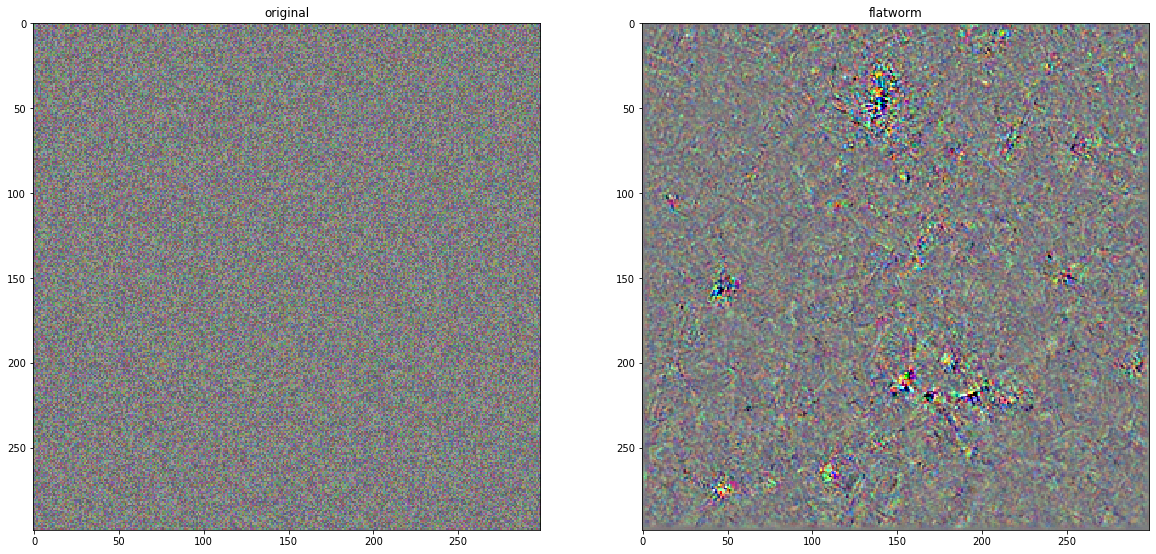

In [12]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 10))

ax1.imshow(deprocess_image(input_img_data.reshape(imgWidth,imgHeight,3)))
ax1.set_title('original')
ax2.imshow(deprocess_image(final_img.reshape(imgWidth,imgHeight,3)))
ax2.set_title('flatworm')
fig.show()

In [14]:
y = [(blob[str(b[0][1])][1], b[1]) for b in np.ndenumerate(model.predict(final_img))]
y.sort(key=lambda a: a[1], reverse=True)
y[:100]

[('water_snake', 0.2479189),
 ('sea_snake', 0.12937003),
 ('bubble', 0.114349864),
 ('sandbar', 0.039768215),
 ('hammerhead', 0.030884342),
 ('starfish', 0.015599268),
 ('spider_web', 0.015459087),
 ('stingray', 0.014928996),
 ('eel', 0.014213152),
 ('loggerhead', 0.014019466),
 ('tray', 0.013788957),
 ('centipede', 0.013377321),
 ('leatherback_turtle', 0.011313211),
 ('jellyfish', 0.009238846),
 ('cockroach', 0.008017376),
 ('fiddler_crab', 0.007042734),
 ('coho', 0.006808188),
 ('American_alligator', 0.0053188754),
 ('crayfish', 0.005069046),
 ('slug', 0.005067005),
 ('nematode', 0.0049784346),
 ('envelope', 0.004229553),
 ('African_crocodile', 0.004179514),
 ('thunder_snake', 0.0040533645),
 ('ant', 0.0040367013),
 ('tennis_ball', 0.00402059),
 ('wing', 0.0039095194),
 ('great_white_shark', 0.003665003),
 ('sturgeon', 0.0035844864),
 ('diamondback', 0.0034825031),
 ('scorpion', 0.0032545666),
 ('goldfish', 0.0030745808),
 ('electric_ray', 0.003028226),
 ('doormat', 0.0029201317),
 (